In [204]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

CSV = Path("data/raw/newData/completo.csv")

# Define los tipos básicos que conoces de antemano  (ajusta si es necesario)
dtype_dict = {
    'idListaCobro': 'Int64',
    'idCredito':    'Int64',
    'consecutivoCobro': 'Int64',
    'idBanco':      'Int8',
    'idRespuestaBanco': 'string',
    'NombreBanco':  'string',
    'NombreEmisora':'string',
    'IdBanco':      'Int8',
    'Emisora':      'string',
    'TipoEnvio':    'string'
}
DF = pd.read_csv(CSV, dtype=dtype_dict, low_memory=False)

print(f"✅  Datos cargados: {DF.shape[0]:,} filas × {DF.shape[1]} columnas")

✅  Datos cargados: 10,057,440 filas × 21 columnas


In [217]:
def mostrar_columnas(df):
    print("🗂️  Columnas:")
    for c in df.columns:
        print(f" • {c}")

def contar_valores(df, col, top_n=20):
    """Cuenta valores (incluye nulos) y los muestra ordenados."""
    vc = df[col].value_counts(dropna=False)
    print(f"🔢 Distintos en «{col}»: {len(vc)}")
    display(vc.head(top_n).to_frame("repeticiones"))


In [218]:
mostrar_columnas(DF)

# Ejemplo de conteos rápidos (banca y banco)
contar_valores(DF, "NombreBanco")
contar_valores(DF, "idBanco")

🗂️  Columnas:
 • idListaCobro
 • idCredito
 • consecutivoCobro
 • idBanco
 • montoExigible
 • montoCobrar
 • montoCobrado
 • fechaCobroBanco
 • idRespuestaBanco
 • NombreBanco
 • DescripcionRespBanco
 • fechaCreacionLista
 • idBanco_lista
 • fechaEnvioCobro
 • idEmisora
 • NombreEmisora
 • IdBanco
 • Emisora
 • TipoEnvio
 • EmisoraCostoAceptado
 • EmisoraCostoDevuelto
 • exito
 • costo
 • doy
 • day_month
🔢 Distintos en «NombreBanco»: 15


,repeticiones
NombreBanco,
BBVA MEXICO,4985164
BANAMEX,3942031
SANTANDER,521543
BANORTE,381549
HSBC,186452
SCOTIABANK,16336
AZTECA,16213
AFIRME,5176
BANCOPPEL,910


🔢 Distintos en «idBanco»: 15


,repeticiones
idBanco,
12,4985164
2,3942031
14,521543
72,381549
21,186452
44,16336
127,16213
62,5176
-119,910


In [221]:
#  Diccionario de categorías
cat_map = {
    'BBVA MEXICO': 1,
    'BANAMEX':     2,
    'SANTANDER':   3,
    'BANORTE':     4
}

# 2. Normaliza el nombre del banco
NB_norm = DF['NombreBanco'].fillna('').str.strip().str.upper()

# 3. Crea la nueva columna (0 = Otros)
DF['idBancoCategoria'] = NB_norm.map(cat_map).fillna(0).astype('uint8')

# 4. (Opcional) etiqueta legible
label_map = {0:'OTROS', 1:'BBVA', 2:'BANAMEX', 3:'SANTANDER', 4:'BANORTE'}
DF['bancoCategoria'] = DF['idBancoCategoria'].map(label_map)

# 5. Verificación rápida
print("Distribución de idBancoCategoria:")
print(DF['idBancoCategoria'].value_counts().sort_index())


Distribución de idBancoCategoria:
idBancoCategoria
0     227153
1    4985164
2    3942031
3     521543
4     381549
Name: count, dtype: int64


In [207]:
# Columnas ‘exito’ y ‘costo’
DF['exito'] = (DF['montoCobrado'] > 0).astype('uint8')  # 1 = cobró algo

DF['costo'] = np.where(
    DF['exito'].eq(1),
    DF['EmisoraCostoAceptado'],
    DF['EmisoraCostoDevuelto']
)

# Sanity-check aleatorio
cols_chk = [
    'idCredito', 'montoCobrar', 'montoCobrado', 'idRespuestaBanco',
    'EmisoraCostoAceptado', 'EmisoraCostoDevuelto', 'costo', 'exito'
]
display(DF.sample(5)[cols_chk])

,idCredito,montoCobrar,montoCobrado,idRespuestaBanco,EmisoraCostoAceptado,EmisoraCostoDevuelto,costo,exito
7599922,678995,626.76,0.0,04,8.00,0.00,0.00,0
1373658,460691,209.30,0.0,04,1.75,1.75,1.75,0
6668822,696905,249.07,0.0,04,4.00,0.00,0.00,0
762437,538294,429.95,0.0,04,1.75,1.75,1.75,0
1457724,397648,2798.29,0.0,04,1.75,1.75,1.75,0


In [208]:
# Resumen simple de éxitos / fallos
num_exitos = int(DF['exito'].sum())
num_fallos = int(len(DF) - num_exitos)
print(f"Cobros exitosos : {num_exitos:,}")
print(f"Cobros fallidos : {num_fallos:,}")

Cobros exitosos : 378,066
Cobros fallidos : 9,679,374


In [209]:
# Resumen anual con porcentaje de éxito
# ⇢ Parseo de fecha (se hace una sola vez)
DF['fechaCreacionLista'] = pd.to_datetime(
    DF['fechaCreacionLista'], dayfirst=True, errors='coerce'
)

resumen = (DF
           .groupby(DF['fechaCreacionLista'].dt.year)['exito']
           .agg(fallos=lambda x: (x == 0).sum(),
                exitos=lambda x: (x == 1).sum())
          )

resumen['pct_exito'] = (resumen['exitos'] / resumen.sum(axis=1) * 100).round(2)
resumen['pct_fallo'] = 100 - resumen['pct_exito']

display(resumen)

,fallos,exitos,pct_exito,pct_fallo
fechaCreacionLista,,,,
2022,346331,14681,4.07,95.93
2023,1613431,67931,4.04,95.96
2024,5693728,207166,3.51,96.49
2025,2025884,88288,4.18,95.82


In [210]:
# ⇢ Asegúrate de que la columna de fecha sea tipo datetime
DF['fechaCreacionLista'] = pd.to_datetime(
    DF['fechaCreacionLista'],
    dayfirst=True,
    errors='coerce'
)

# ⇢ Agrupar directamente por año extraído
resumen = (DF
           .groupby(DF['fechaCreacionLista'].dt.year)['exito']
           .value_counts()
           .unstack(fill_value=0)
           .rename(columns={0: 'fallos', 1: 'exitos'})
           .sort_index())

# ⇢ Calcular porcentaje de éxitos
resumen['pct_exito'] = (resumen['exitos'] / resumen.sum(axis=1) * 100).round(2)
resumen['pct_fallo'] = 100 - resumen['pct_exito']  # opcional

print(resumen)

exito                fallos  exitos  pct_exito  pct_fallo
fechaCreacionLista                                       
2022                 346331   14681       4.07      95.93
2023                1613431   67931       4.04      95.96
2024                5693728  207166       3.51      96.49
2025                2025884   88288       4.18      95.82


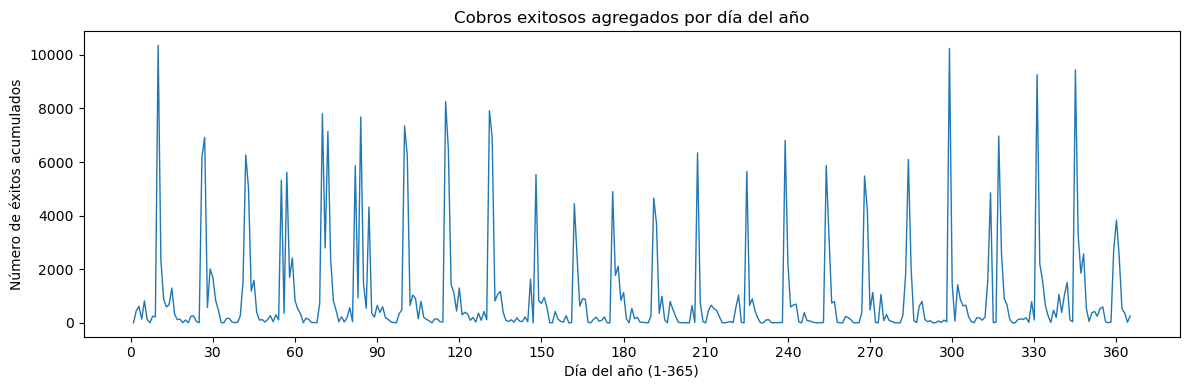

In [213]:
DF['doy'] = DF['fechaCreacionLista'].dt.dayofyear          # 1-365/366
serie_doy = (
    DF.loc[DF['exito'] == 1]
      .groupby('doy')
      .size()
      .reindex(range(1, 366), fill_value=0)               # rellena días sin datos
)

plt.figure(figsize=(12, 4))
plt.plot(serie_doy.index, serie_doy.values, linewidth=1)
plt.title('Cobros exitosos agregados por día del año')
plt.xlabel('Día del año (1-365)')
plt.ylabel('Número de éxitos acumulados')
plt.xticks(range(0, 366, 30))                             # marcas cada ~mes
plt.tight_layout()
plt.show()

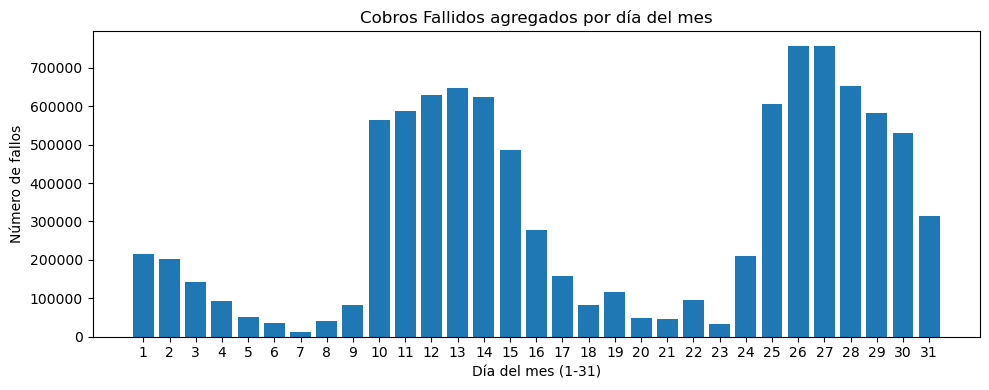

In [237]:
# Días del MES (1-31) con más fallos  ----------------------------
# (cambia exito==0 a ==1 si quieres éxitos)

DF['day_month'] = DF['fechaCreacionLista'].dt.day          # 1-31

serie_dom = (
    DF.loc[DF['exito'] == 0]        # 0 = fallos  |  1 = éxitos
      .groupby('day_month')
      .size()
      .reindex(range(1, 32), fill_value=0)   # rellena días 29-31 si faltan
)

plt.figure(figsize=(10, 4))
plt.bar(serie_dom.index, serie_dom.values)
plt.title('Cobros Fallidos agregados por día del mes')
plt.xlabel('Día del mes (1-31)')
plt.ylabel('Número de fallos')
plt.xticks(range(1, 32))
plt.tight_layout()
plt.show()

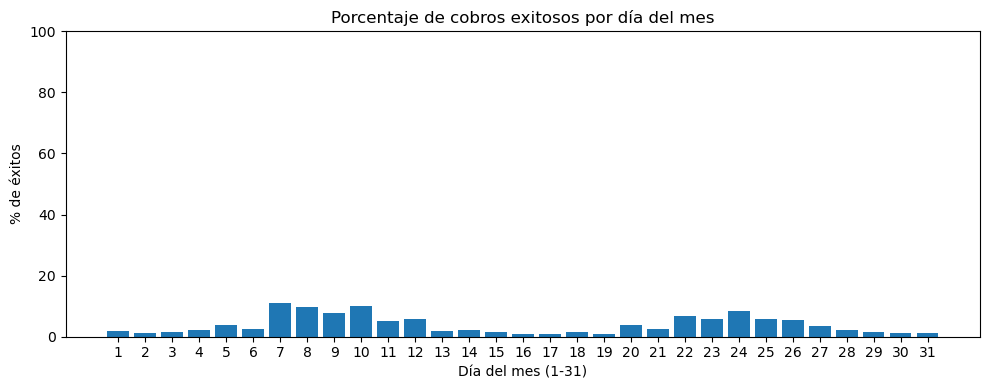

In [224]:
# 1️⃣  Extrae el número de día (1-31)
DF['dia_mes'] = DF['fechaCreacionLista'].dt.day

# 2️⃣  Totales y éxitos por día
totales_por_dia  = DF.groupby('dia_mes').size()
exitos_por_dia   = DF.loc[DF['exito'] == 1].groupby('dia_mes').size()

# 3️⃣  Calcula porcentaje de éxito
pct_exito = (
    (exitos_por_dia / totales_por_dia)      # divide Series; índices 1-31
      .reindex(range(1, 32), fill_value=0)  # asegura los 31 días
      .mul(100)                             # convierte a %
      .round(2)
)

# 4️⃣  Gráfica
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(pct_exito.index, pct_exito.values)
plt.title('Porcentaje de cobros exitosos por día del mes')
plt.xlabel('Día del mes (1-31)')
plt.ylabel('% de éxitos')
plt.xticks(range(1, 32))
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [238]:
mostrar_columnas(DF)


🗂️  Columnas:
 • idListaCobro
 • idCredito
 • consecutivoCobro
 • idBanco
 • montoExigible
 • montoCobrar
 • montoCobrado
 • fechaCobroBanco
 • idRespuestaBanco
 • NombreBanco
 • DescripcionRespBanco
 • fechaCreacionLista
 • idBanco_lista
 • fechaEnvioCobro
 • idEmisora
 • NombreEmisora
 • IdBanco
 • Emisora
 • TipoEnvio
 • EmisoraCostoAceptado
 • EmisoraCostoDevuelto
 • exito
 • costo
 • doy
 • day_month
 • idBancoCategoria
 • bancoCategoria
 • dia_mes
